In [8]:
import os
import sys

import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

get_ipython().magic(u'matplotlib inline')

sys.path.append('../3_analyze')
from containers import Dataset
from utils import export, show_side_by_side, show_features
from statistics import Statistics
from prob_opt import PredictStructs

/share/PI/rondror/software/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [9]:
data_dir = '/scratch/PI/rondror/jbelk/method/data'
glide_dir = 'docking/glide12'
ifp_dir = 'ifp/ifp3'
mcss_dir = 'mcss/mcss1'

struct_dict = {'AR':'2PNU','A2AR':'2YDO','B1AR':'2VT4','B2AR':'2RH1','CHK1':'2BRN', 'PLK1':'2OWB',
               'VITD':'2HB7','BRAF':'3IDP','JAK2':'3KRR','CDK2':'1H1S','ERA':'1A52','GCR':'3K23'}

features = {
    'mcss':[],
    'hbond':[2,3],
    'sb':[4],
    'pipi':[6],
    #'picat':[7,8],
    'contact':[11]
}

warning, only 17 ligands found for JAK2
sb


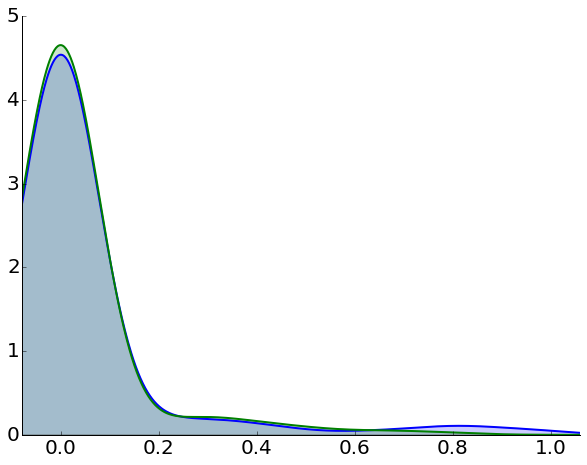

mcss


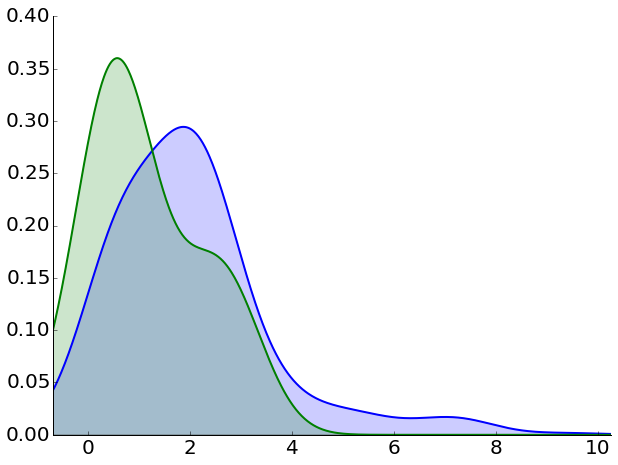

contact


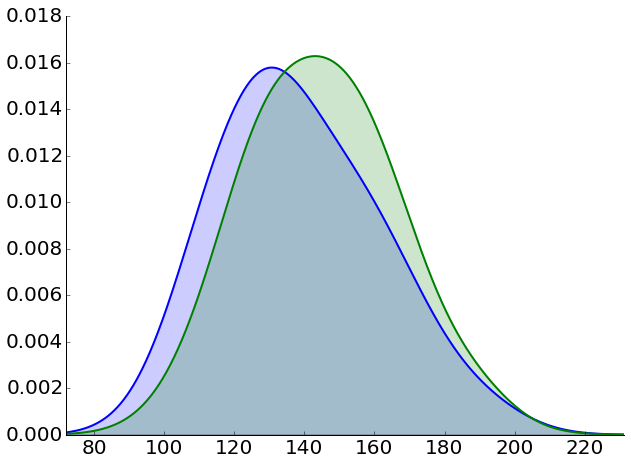

pipi


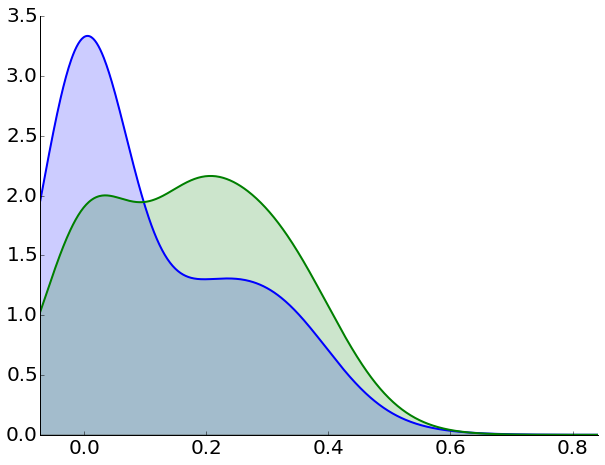

hbond


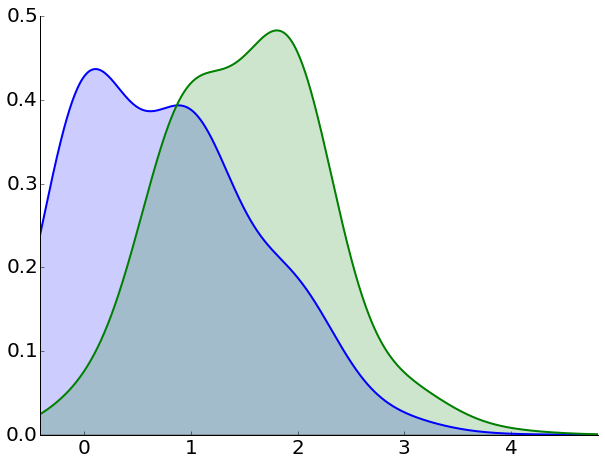

In [10]:
num_stats_ligs = 20

stats_prots = ['JAK2']#['CHK1','B1AR','ERA']

stats_data = Dataset(stats_prots, struct_dict, data_dir, glide_dir, ifp_dir, mcss_dir)
stats_data.load({p:prot.lm.get_pdb() for p,prot in stats_data.proteins.items()})

stats = Statistics(stats_data, stats_prots, num_stats_ligs, 100, features, 0.5)

for f_name in features.keys():
    print f_name#, stats.evidence.std[f_name]
    stats.show_stats(f_name, raw=False, smoothed=True)
    #stats.show_stats_by_pair(f_name, raw=False, smoothed=True)

In [4]:
predict_prots = ['CDK2']
predict_data = Dataset(predict_prots, struct_dict, data_dir, glide_dir, ifp_dir, mcss_dir)

In [5]:
num_chembl = 3
num_poses = 100
t = 10

error = {}

for p,prot in predict_data.proteins.items():
    
    ps = PredictStructs(prot.docking, stats.evidence, features, num_poses, t)
    
    us_rmsds = []
    glide_rmsds = []
    
    for q in ['2VTN_lig']:#prot.lm.get_pdb():
        chembl_ligs = prot.lm.get_similar(q, num=num_chembl)
        predict_data.load({p:[q]+chembl_ligs})
        
        best_cluster, en_landscape = ps.max_posterior(chembl_ligs, verbose=True, sampling=1, en_landscape=False)
        
        our_scores = ps.score_query(q, best_cluster)
        us_top = np.argmax(our_scores)
        rmsds = [po.rmsd for po in prot.docking.ligands[q].poses[:num_poses]]
        print q, us_top, rmsds[us_top], 0, rmsds[0]
        us_rmsds.append(rmsds[us_top])
        glide_rmsds.append(rmsds[0])
              
        if rmsds[us_top] > 2:
            best_cluster[q] = us_top
            error[q] = best_cluster
        
    print 'our ave rmsd:',np.mean(us_rmsds)
    print 'glide ave rmsd:',np.mean(glide_rmsds)

CHEMBL2426396_lig CHEMBL2426384_lig 0 0 10000.0 0.909090909091
CHEMBL2426396_lig CHEMBL2426384_lig 0 1 10000.0 0.909090909091
CHEMBL2426396_lig CHEMBL2426384_lig 0 2 10000.0 0.909090909091
CHEMBL2426396_lig CHEMBL2426384_lig 0 3 10000.0 0.909090909091
CHEMBL2426396_lig CHEMBL2426384_lig 0 4 10000.0 0.909090909091
CHEMBL2426396_lig CHEMBL2426384_lig 0 5 10000.0 0.909090909091
CHEMBL2426396_lig CHEMBL2426384_lig 0 6 10000.0 0.909090909091
CHEMBL2426396_lig CHEMBL2426384_lig 0 7 10000.0 0.909090909091
CHEMBL2426396_lig CHEMBL2426384_lig 0 8 10000.0 0.909090909091
CHEMBL2426396_lig CHEMBL2426384_lig 0 9 10000.0 0.909090909091
CHEMBL2426396_lig CHEMBL2426384_lig 0 10 10000.0 0.909090909091
CHEMBL2426396_lig CHEMBL2426384_lig 0 11 10000.0 0.909090909091
CHEMBL2426396_lig CHEMBL2426384_lig 0 12 10000.0 0.909090909091
CHEMBL2426396_lig CHEMBL2426384_lig 0 13 10000.0 0.909090909091
CHEMBL2426396_lig CHEMBL2426384_lig 0 14 10000.0 0.909090909091
CHEMBL2426396_lig CHEMBL2426384_lig 0 15 10000.0 0

../3_analyze/prob_opt.py:72: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
predict_data.assign_weights({2:1,3:1,4:1,6:1,11:0.005})

size = 2
show_prob = True
show_x = True
export_poses = False

for q, our_poses in error.items():
    glide_poses = {l:0 for l in our_poses}
    
    us_top = ps.ligset.get_poses(our_poses)
    glide_top = ps.ligset.get_poses(glide_poses)
    
    l_list = [q] + sorted([l for l in us_top if l != q])
    show_side_by_side(us_top, glide_top, l_list, 
                      t1='Our Top Poses', t2='Glide Top Poses', num_i=10, size=size)

    for k,kdef in features.items():
        x1, log_p1 = ps.x(our_poses,k,kdef,lig_order=l_list)
        x2, log_p2 = ps.x({l:0 for l in l_list},k,kdef,lig_order=l_list)

        if show_prob and np.sum(log_p1) != 0:
            print k, 'probability matrix'
            minval = min(np.min(log_p1[np.nonzero(log_p1)]),np.min(log_p2[np.nonzero(log_p2)]))
            maxval = max(np.max(log_p1[np.nonzero(log_p1)]),np.max(log_p2[np.nonzero(log_p2)]))

            show_features(us_top, log_p1, glide_top, log_p2, l_list, 
                          'us top','glide top',size=size, mi=minval,ma=maxval)

        if show_x:
            print k, 'x_k matrix'
            minval = min(np.min(x1),np.min(x2))
            maxval = max(np.max(x1),np.max(x2))

            show_features(us_top, x1, glide_top, x2, l_list, 
                          'us top','glide top',size=size,mi=minval,ma=maxval)
            
    # this will show up in /scratch/PI/rondror/jbelk/method/outputs
    if export_poses: 
        export(data_dir, us_top, '{}_us_apr'.format(q), p, 
               struct=struct_dict[p], verbose=False, glide_dir=glide_dir)
        export(data_dir, glide_top, '{}_glide_apr'.format(q), p, 
               struct=struct_dict[p], verbose=False, glide_dir=glide_dir)